## Text Classification

In [1]:
import os
import spacy
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.legacy import data

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from IPython.display import clear_output

from utils import *
from config import RCNNConfig
from rcnn import RCNN
from training import train_model, evaluate

import warnings
warnings.filterwarnings('ignore')

### Read data from CSV file

In [2]:
data_df = pd.read_csv("../data/spam.csv")

In [3]:
data_df

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [4]:
print(len(data_df[data_df['label'] == 'spam']))
print(len(data_df[data_df['label'] == 'ham']))

747
4825


### Split data to train and validation

In [5]:
train_df, valid_df = train_test_split(data_df, test_size=0.1, random_state=1)

In [6]:
print(len(train_df), len(valid_df))

5014 558


In [7]:
train_df.to_csv('../data/spam-train.csv', index=False)
valid_df.to_csv('../data/spam-valid.csv', index=False)

In [8]:
train_df = pd.read_csv('../data/spam-train.csv')
valid_df = pd.read_csv('../data/spam-valid.csv')

valid_df

,label,text
0,ham,Convey my regards to him
1,ham,"[‰Û_] anyway, many good evenings to u! s"
2,ham,My sort code is and acc no is . The bank is n...
3,ham,Sorry i din lock my keypad.
4,spam,"Hi babe its Chloe, how r u? I was smashed on s..."
...,...,...
553,ham,Tyler (getting an 8th) has to leave not long a...
554,ham,K. I will sent it again
555,ham,Sday only joined.so training we started today:)
556,spam,FreeMsg Hey there darling it's been 3 week's n...


### Using torchtext
1. Define fields
2. Define datasets (train, validation, test)
3. Build vocabulary for each field
3. Define iterators for each dataset

In [9]:
TEXT = data.Field(tokenize='spacy')

LABEL = data.LabelField()

In [10]:
train_data, valid_data = data.TabularDataset.splits(
    path="../data/",
    train='spam-train.csv',
    validation='spam-valid.csv',
    format='CSV',
    skip_header=True,
    fields=[('label', LABEL), ('text', TEXT)]
)

print(vars(train_data[0]))
print(vars(valid_data[0]))

{'label': 'ham', 'text': ['Gud', 'gud', '..', 'k', ',', 'chikku', 'tke', 'care', '..', 'sleep', 'well', 'gud', 'nyt']}
{'label': 'ham', 'text': ['Convey', 'my', 'regards', 'to', 'him']}


In [11]:
# Build vocabulary for texts
vocab_size = 20_000

TEXT.build_vocab(train_data,
                 max_size=vocab_size)

# Build vocabulary for labels
LABEL.build_vocab(train_data)
print(LABEL.vocab.stoi)

defaultdict(None, {'ham': 0, 'spam': 1})


In [12]:
batch_size = 8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator = data.BucketIterator(
    train_data, 
    batch_size, 
    sort_key=lambda x: len(x.text), 
    device=device)

valid_iterator = data.BucketIterator(
    valid_data, 
    batch_size, 
    sort_key=lambda x: len(x.text), 
    device=device,
    train=False,
    shuffle=False)

## Build Model

In [13]:
config = RCNNConfig()

model = RCNN(config, vocab_size)
model = model.to(device)

optimizer = optim.Adam(model.parameters())
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
criterion = nn.CrossEntropyLoss().to(device)

## Train the model

In [14]:
model_dir = 'models'
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
    
fname = f'{model_dir}/rcnn.pt'  # save the trained model

In [15]:
# train the model
train_model(model, device, 
            train_iterator, valid_iterator, 
            optimizer, criterion, scheduler, 
            n_epochs=5, 
            fname=fname)

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Time
0,1,0.230,0.103,90.88,96.43,0m 8s
1,2,0.076,0.082,97.97,97.32,0m 8s
2,3,0.045,0.158,99.12,95.00,0m 8s
3,4,0.035,0.106,99.34,96.79,0m 8s
4,5,0.029,0.101,99.46,96.79,0m 8s


In [16]:
loss, acc = evaluate(model, valid_iterator, criterion)
print(f'Validation loss = {loss:.4f} | validation acc = {acc*100:.2f}%')

Validation: | Loss=0.0042 | Acc=1.0000 |: 100%|██████████| 70/70 [00:00<00:00, 246.87it/s]

Validation loss = 0.0816 | validation acc = 97.32%


### Testing model on user inputs

In [17]:
nlp = spacy.load("en_core_web_sm")


def predict(model, sentence, device=device):
    model.eval()
    
    # tokenize
    tokens = [t.text for t in nlp(sentence)]
    
    # numericalize
    indexed = [TEXT.vocab.stoi[t] for t in tokens]
    
    # convert to torch tensor and add batch dimension
    indexed = torch.LongTensor(indexed).unsqueeze(1).to(device)
    
    # predict the label
    prediction = model(indexed)
    
    return LABEL.vocab.itos[prediction.argmax(1).item()]
    

In [18]:
docs = ["Are you ready for the tea party????? It's gonna be wild",
        "URGENT Reply to this message for GUARANTEED FREE TEA"]


for doc in docs:
    label = predict(model, doc)
    display_classification_result(doc, label, LABEL.vocab.stoi[label])

ham     Are you ready for the tea party????? It's gonna be wild
spam    URGENT Reply to this message for GUARANTEED FREE TEA


### Confusion matrix

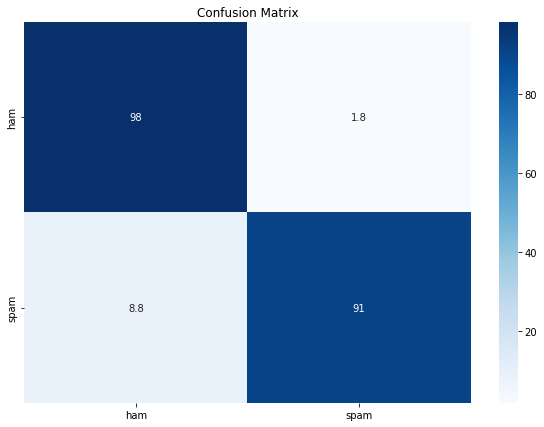

In [19]:
cm, y_true, y_pred = compute_confusion_matrix(model, valid_iterator)
plot_confusion_matrix(cm, LABEL.vocab.stoi)

In [20]:
print(classification_report(y_true, y_pred, target_names=LABEL.vocab.stoi.keys()))

              precision    recall  f1-score   support

         ham       0.99      0.98      0.98       490
        spam       0.87      0.91      0.89        68

    accuracy                           0.97       558
   macro avg       0.93      0.95      0.94       558
weighted avg       0.97      0.97      0.97       558

